# README
This notebook runs a deep learning model (convolutional neural network, Densenet) on images directly. CNNs are trained on both the Base dataset and the Expanded dataset, where the Expanded dataset has the additional task of classifying when hands are not present (and is a harder task and has reduced accuracy.)

CNN Base and CNN Expanded are attempted in this file

# Setup

In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset
from datasets import DatasetDict

#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import PIL
import shutil
import os
import pickle
import time

from torch import nn
from tqdm import tqdm

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image

toImage = transforms.Compose([
    transforms.ToPILImage(),
])

In [ ]:
annotated_ds = load_dataset("conjunct/rps_annotated")

eval_ds = annotated_ds['test'].filter(lambda x: x['src'] != 2 and x['landmarks'])
eval_ds = eval_ds.remove_columns(['raw', 'annotated', 'landmarks', 'landmarks_old', 'pca'])
ds = annotated_ds.remove_columns(['raw', 'annotated', 'landmarks', 'landmarks_old', 'pca'])

Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
# construct train/val/test split by splitting the train
# 90% train, 10% test + validation
# Split the 10% test + valid in half test, half valid
train_valid = ds['train'].train_test_split(test_size=0.05, seed=42) # this shuffles
split_ds = DatasetDict({
    'train': train_valid['train'],
    'valid': train_valid['test'],
    'test': ds['test']})

In [ ]:
ds.set_format('torch')
split_ds.set_format('torch')
eval_ds.set_format('torch')

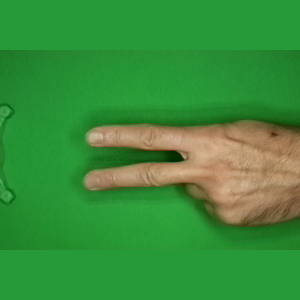

In [ ]:
toImage(split_ds['train'][0]['image'])  # indeed it is shuffled

In [ ]:
for i in range(1000):
    if split_ds['valid'][0]['image'].shape != torch.Size([3, 300, 300]):
        print(i)

# CNN (Densenet)

https://pytorch.org/vision/main/models/generated/torchvision.models.densenet161.html

Dependencies: ds_shuffled

### Data Setup

In [ ]:
# more data augmentation techniques available at https://pytorch.org/vision/stable/transforms.html:
# see ColorJitter, RandomRotation,

# Define a function to discard the alpha layer

old_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(256),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    # get transforms from densenet161
    # https://pytorch.org/vision/main/models/generated/torchvision.models.densenet161.html
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #affects the color

    transforms.ToPILImage(),

])

In [ ]:
# more data augmentation techniques available at https://pytorch.org/vision/stable/transforms.html:
# see ColorJitter, RandomRotation,


_ToTensor = transforms.ToTensor()
_ToPIL = transforms.ToPILImage()
def idem_to_tensor(x):
    if not torch.is_tensor(x):
        return _ToTensor(x)
    return x
def idem_to_PIL(x):
    if isinstance(x, PIL.Image.Image):
        return x
    return _ToPIL(x)

# Define a function to discard the alpha layer for batches
# def discard_alpha_batch(obj):
#     return obj[:, :3, :, :]

transform = transforms.Compose([
    transforms.Lambda(idem_to_tensor),

    # transforms.Lambda(discard_alpha_batch),
    # get transforms from densenet161
    # torchvision.models.DenseNet161_Weights.DEFAULT.transforms()
    # https://pytorch.org/vision/main/models/generated/torchvision.models.densenet161.html
    torchvision.models.DenseNet161_Weights.DEFAULT.transforms(),

    # transforms.Lambda(idem_to_PIL),
])

In [ ]:
# create dataloaders for train and validation
# split train into train and validation
ds.set_format('torch')
print(ds['train'][0]['image'].shape)

# why is it a different format as transforms.ToTensor() ;-;
# https://github.com/huggingface/datasets/issues/6394 ;---;
# need to convert [300,300,4] --> [4,300,300], if applicable. This seems to have been fixed

torch.Size([3, 300, 300])


In [ ]:
# def permute_image(example):
#     original_image = example['image']  # Assuming 'image' is the key for the image tensor
#     permuted_image = original_image.permute(0, 3, 1, 2)  # Permute dimensions for batch size of 8
#     example['image'] = permuted_image  # Update the example with the permuted image
#     return example

# # Apply the function to the entire dataset
# permuted_dataset = ds_shuffled.map(permute_image, batched=True, batch_size=8)
# permuted_dataset.set_format('torch', dtype=torch.uint8) # of course huggingface converts it to int64

## On Expanded

In [ ]:
train_dl = DataLoader(split_ds['train'], batch_size=32, shuffle=True)
val_dl = DataLoader(split_ds['valid'], batch_size=32, shuffle=False)
tensor_img = next(iter(val_dl))['image']
print(tensor_img.shape)
print(tensor_img[0].shape)

test_dl = DataLoader(split_ds['test'], batch_size=32, shuffle=True)
tensor_img[0,1,:,100], tensor_img.dtype

torch.Size([32, 3, 300, 300])
torch.Size([3, 300, 300])


(tensor([153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
         153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
         153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
         153, 153, 153, 153, 153, 153, 153, 153, 140, 140, 140, 141, 141, 140,
         141, 142, 142, 143, 142, 142, 143, 145, 139, 133, 126, 121, 120, 115,
         112,  83,  93, 110, 126, 125, 134, 140, 144, 148, 147, 148, 145, 136,
         130, 124, 113, 101,  76,  48,  40,  57,  56,  64,  90,  91, 103, 111,
         119, 124, 126, 134, 141, 143, 145, 144, 142, 141, 137, 130, 108,  88,
          97, 100, 101, 113, 121, 123, 125, 128, 134, 136, 132, 136, 137, 130,
         128, 124, 122, 122, 121, 114, 100,  80, 108, 116, 120, 122, 123, 128,
         132, 133, 132, 140, 140, 139, 138, 135, 130, 123, 121, 119, 117, 112,
         104,  97,  76,  68,  75, 113, 119, 128, 130, 133, 132, 140, 142, 150,
         153, 153, 155, 156, 154, 154, 154, 154, 155

In [ ]:
eval_dl = DataLoader(eval_ds, batch_size=32, shuffle=True)

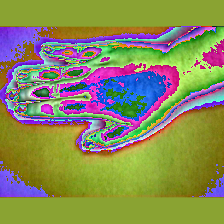

In [ ]:
idem_to_PIL(transform(tensor_img)[0])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from tqdm import tqdm

def validation(model, val_dl, criterion):
    val_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():

        model.eval()
        for _, obj in tqdm(enumerate(val_dl)):
            inputs = obj['image']
            targets = obj['label']

            inputs = transform(inputs)
            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = model(inputs)
            loss_t = criterion(predictions,targets)
            val_loss+=loss_t.item()
            correct += (predictions.argmax(1) == targets).sum().item()
            total += targets.size(0)
    print(f'validation loss: {val_loss/len(val_dl)}, validation acc: {(100 * correct/total):.4f}\n')
    model.train()

### Option 1: load pretrained model

In [ ]:
model = torchvision.models.densenet161(weights=None)
model = model.to(device)

In [ ]:
!gdown 1_lZ2L0g4D352bDm06a-6JK7DAcWfTzKc
model.load_state_dict(torch.load("model-rps.9.pt", map_location=device))

Downloading...
From (original): https://drive.google.com/uc?id=1_lZ2L0g4D352bDm06a-6JK7DAcWfTzKc
From (redirected): https://drive.google.com/uc?id=1_lZ2L0g4D352bDm06a-6JK7DAcWfTzKc&confirm=t&uuid=9b36a44b-fc3b-4725-b8e0-667ab116d879
To: /content/model-rps.9.pt
100% 116M/116M [00:01<00:00, 92.5MB/s]


<All keys matched successfully>

### Option 2: Fine tuning from scratch

In [ ]:
# image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
# model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model = torchvision.models.densenet161(weights='DEFAULT')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 83.8MB/s]


In [ ]:
def train_model(train_dl, val_dl, model, from_epoch=0, to_epoch=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # , lr=0.01, momentum=0.9)

    # let's do 5 epochs
    for epoch in range(from_epoch, to_epoch):
        # progress bar for each epoch
        loop = tqdm(train_dl)
        loop.set_description(f"Epoch [{epoch}/{to_epoch}]")

        train_loss = 0
        train_acc = 0
        total = 0
        for _, obj in enumerate(loop):
            inputs = obj['image']
            targets = obj['label']

            optimizer.zero_grad() # clear the gradients

            inputs = transform(inputs)
            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = model(inputs) # compute the model output
            loss = criterion(predictions, targets) # , targets.reshape(-1, 1)) # calculate loss

            loss.backward() # credit assignment
            optimizer.step()  # update model weights

            train_loss += loss.item() * inputs.size(0)
            train_acc += (predictions.argmax(1) == targets).sum().item()
            total += inputs.size(0)
            # if total % 1000 == 0:
                # print(f"train_loss: {train_loss/total}, train_acc: {train_acc/total}")

        print(f"train_loss: {train_loss/len(train_dl.sampler)}, train_acc: {train_acc/len(train_dl.sampler)}")
        validation(model, val_dl, criterion)

        # save the model
        torch.save(model.state_dict(), f'model-rps.{epoch}.pt')

In [ ]:
start = time.time()
train_model(train_dl, val_dl, model)
end = time.time()
print('Training Time:', start - end)

Epoch [0/5]:  46%|████▌     | 125/273 [01:48<02:09,  1.14it/s]

train_loss: 0.3705893200300634, train_acc: 0.93075


Epoch [0/5]:  92%|█████████▏| 250/273 [03:36<00:20,  1.14it/s]

train_loss: 0.23566367520275525, train_acc: 0.950625


Epoch [0/5]: 100%|██████████| 273/273 [03:56<00:00,  1.16it/s]


train_loss: 0.22009237293131978, train_acc: 0.9540810469521295
validation loss: 0.004428037110483274, validation acc: 100.0000



Epoch [1/5]:  46%|████▌     | 125/273 [01:48<02:09,  1.14it/s]

train_loss: 0.03953285139636137, train_acc: 0.9905


Epoch [1/5]:  92%|█████████▏| 250/273 [03:37<00:19,  1.16it/s]

train_loss: 0.02632882100576535, train_acc: 0.99375


Epoch [1/5]: 100%|██████████| 273/273 [03:56<00:00,  1.15it/s]


train_loss: 0.025209292795839677, train_acc: 0.9941453334863966
validation loss: 0.031930996493611016, validation acc: 99.5643



Epoch [2/5]:  46%|████▌     | 125/273 [01:48<02:04,  1.18it/s]

train_loss: 0.026491681235609577, train_acc: 0.99275


Epoch [2/5]:  92%|█████████▏| 250/273 [03:37<00:19,  1.17it/s]

train_loss: 0.058849487229948864, train_acc: 0.98175


Epoch [2/5]: 100%|██████████| 273/273 [03:56<00:00,  1.16it/s]


train_loss: 0.06626389366108977, train_acc: 0.9792216737458386
validation loss: 0.33945987472931544, validation acc: 90.6318



Epoch [3/5]:  46%|████▌     | 125/273 [01:48<02:07,  1.16it/s]

train_loss: 0.03646977750421502, train_acc: 0.9895


Epoch [3/5]:  92%|█████████▏| 250/273 [03:36<00:20,  1.15it/s]

train_loss: 0.03148043150187004, train_acc: 0.9915


Epoch [3/5]: 100%|██████████| 273/273 [03:55<00:00,  1.16it/s]


train_loss: 0.029027683114808942, train_acc: 0.992193777981862
validation loss: 0.02178632081777323, validation acc: 99.7821



Epoch [4/5]:  46%|████▌     | 125/273 [01:48<02:07,  1.16it/s]

train_loss: 0.020291238110279664, train_acc: 0.99475


Epoch [4/5]:  92%|█████████▏| 250/273 [03:37<00:20,  1.12it/s]

train_loss: 0.01554802985736751, train_acc: 0.996125


Epoch [4/5]: 100%|██████████| 273/273 [03:56<00:00,  1.15it/s]


train_loss: 0.016163422076114743, train_acc: 0.9959820916083113
validation loss: 0.003180531901307404, validation acc: 100.0000

Training Time: -1212.14870595932


Train time: 3:56 * 5 = 19:41 on GPU

### Evaluation

In [ ]:
validation(model, test_dl, nn.CrossEntropyLoss())

In [ ]:
# inference
def peek_inference(dl):
    # test it out by taking a peek
    batch = next(iter(dl))
    #images = batch[:8,:,:,:]['image']
    #lbls = batch[:8]['label']
    images = batch['image']
    lbls = batch['label']
    # take one batch
    # only take 8 samples from the batch
    inputs = transform(images).to(device)
    with torch.no_grad():
        outs = model(inputs)
        outs = outs.argmax(1)
        print(outs.shape)

        pairs = zip(lbls.tolist(), outs.tolist())

        for i, (lbl, out) in enumerate(pairs):
            print(f"expected: {decode_label(lbl)}, predicted: {decode_label(out)}")
            img = idem_to_PIL(images[i])
            print(img.size)
            # print(type(img))
            display(img)
peek_inference(test_dl)

Output hidden; open in https://colab.research.google.com to view.

Keep training

In [ ]:
train_model(train_dl, val_dl, model, 5, 10)

Epoch [5/5]: 100%|██████████| 273/273 [04:04<00:00,  1.12it/s]


train_loss: 0.03730576517839637, train_acc: 0.9903570198599472
validation loss: 0.012204159655084368, validation acc: 99.5643



Epoch [6/5]: 100%|██████████| 273/273 [03:59<00:00,  1.14it/s]


train_loss: 0.023060813471164274, train_acc: 0.9941453334863966
validation loss: 0.0017562632254945734, validation acc: 100.0000



Epoch [7/5]: 100%|██████████| 273/273 [03:55<00:00,  1.16it/s]


train_loss: 0.024824824004705127, train_acc: 0.9935713465732982
validation loss: 0.002104436117770092, validation acc: 100.0000



Epoch [8/5]: 100%|██████████| 273/273 [03:53<00:00,  1.17it/s]


train_loss: 0.03193700761678232, train_acc: 0.9911606015382849
validation loss: 0.004164692656680321, validation acc: 99.7821



Epoch [9/5]: 100%|██████████| 273/273 [03:53<00:00,  1.17it/s]


train_loss: 0.013015009981684105, train_acc: 0.996096888990931
validation loss: 0.010954855156160192, validation acc: 99.7821



In [ ]:
validation(model, test_dl, nn.CrossEntropyLoss())

validation loss: 0.00842743159403625, validation acc: 99.8526



In [ ]:
torch.cuda.empty_cache()

## On base

In [ ]:
base_ds = split_ds.filter(lambda x: x['src'] == 0)

Filter:   0%|          | 0/8711 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
train_base_dl = DataLoader(base_ds['train'], batch_size=32, shuffle=True)
val_base_dl = DataLoader(base_ds['valid'], batch_size=32, shuffle=False)

test_base_dl = DataLoader(base_ds['test'], batch_size=32, shuffle=True)
tensor_img[0,1,:,100], tensor_img.dtype

(tensor([153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
         153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
         153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
         153, 153, 153, 153, 153, 153, 153, 153, 140, 140, 140, 141, 141, 140,
         141, 142, 142, 143, 142, 142, 143, 145, 139, 133, 126, 121, 120, 115,
         112,  83,  93, 110, 126, 125, 134, 140, 144, 148, 147, 148, 145, 136,
         130, 124, 113, 101,  76,  48,  40,  57,  56,  64,  90,  91, 103, 111,
         119, 124, 126, 134, 141, 143, 145, 144, 142, 141, 137, 130, 108,  88,
          97, 100, 101, 113, 121, 123, 125, 128, 134, 136, 132, 136, 137, 130,
         128, 124, 122, 122, 121, 114, 100,  80, 108, 116, 120, 122, 123, 128,
         132, 133, 132, 140, 140, 139, 138, 135, 130, 123, 121, 119, 117, 112,
         104,  97,  76,  68,  75, 113, 119, 128, 130, 133, 132, 140, 142, 150,
         153, 153, 155, 156, 154, 154, 154, 154, 155

In [ ]:
# image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
# model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model_base = torchvision.models.densenet161(weights='DEFAULT')
model_base = model_base.to(device)

In [ ]:
train_model(train_base_dl, val_base_dl, model_base)

Epoch [0/5]: 100%|██████████| 76/76 [01:02<00:00,  1.21it/s]


train_loss: 0.23286151220677367, train_acc: 0.9671244277985851
validation loss: 0.17537224106490612, validation acc: 92.3077



Epoch [1/5]: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


train_loss: 0.030855283465214527, train_acc: 0.9912609238451935
validation loss: 0.00016909451733226888, validation acc: 100.0000



Epoch [2/5]: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


train_loss: 0.018868553686427796, train_acc: 0.9970869746150645
validation loss: 9.160669105767738e-05, validation acc: 100.0000



Epoch [3/5]: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


train_loss: 0.0012087705567412471, train_acc: 0.9995838535164377
validation loss: 4.69417013846396e-05, validation acc: 100.0000



Epoch [4/5]: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


train_loss: 0.0016872544534908647, train_acc: 0.9995838535164377
validation loss: 0.009374371380545199, validation acc: 100.0000



In [ ]:
validation(model_base, test_base_dl, nn.CrossEntropyLoss())

validation loss: 0.009427900755933175, validation acc: 100.0000

